# Clustering de diálogos en *Harry Potter*

**Objetivo:** explorar patrones narrativos y emocionales en diálogos de la saga mediante análisis exploratorio (EDA) y técnicas de *clustering* no supervisado (K-Means y Gaussian Mixture Models).

**Idea central:** agrupar diálogos similares (por tono/emoción y longitud) para identificar tipos de escenas y comparar el comportamiento de K-Means (clusters compactos) vs GMM (clusters con formas más flexibles).


In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

pd.set_option('display.max_columns', 200)


In [2]:
# Carga robusta (GitHub/Local/Colab)
DATA_CANDIDATES = [
    Path('data/harry_potter_data.csv'),
    Path('harry_potter_data.csv'),
    Path('../data/harry_potter_data.csv'),
]

# (Opcional) si trabajas en Colab con Drive montado, define una ruta directa:
LOCAL_FALLBACK = None  # ejemplo: '/content/drive/MyDrive/train/harry_potter_data.csv'


def load_hp_data() -> pd.DataFrame:
    for p in DATA_CANDIDATES:
        if p.exists():
            print(f'Cargando datos desde: {p}')
            return pd.read_csv(p)

    if LOCAL_FALLBACK is not None and Path(LOCAL_FALLBACK).exists():
        print(f'Cargando datos desde ruta local: {LOCAL_FALLBACK}')
        return pd.read_csv(LOCAL_FALLBACK)

    raise FileNotFoundError(
    """No se encontró 'harry_potter_data.csv'.

Opciones:
- Colócalo en data/harry_potter_data.csv
- Colócalo en la misma carpeta del notebook
- Define LOCAL_FALLBACK con una ruta válida
"""
)


df = load_hp_data()
print('Dimensiones:', df.shape)
df.head(3)


Cargando datos desde: harry_potter_data.csv
Dimensiones: (7444, 38)


,Dialogue ID,Chapter ID,Place ID,Character ID,Dialogue,Chapter Name,Movie ID,Movie Chapter,Movie Title,Release Year,Runtime,Budget,Box Office,Place Name,Place Category,Character Name,Species,Gender,House,Patronus,Wand (Wood),Wand (Core),spells_found,first_spell_found,Spell ID,Incantation,Spell Name,Effect,Light,spell,other_sentiment,joy,sadness,anger,surprise,disgust,fear,K-Means_Cluster
0,1,1,8,4,I should have known that you would be here...P...,Doorstep Delivery,1,1,Harry Potter and the Philosopher's Stone,2001,152,"$125,000,000","$1,002,000,000",4 Privet Drive,Dwellings,Albus Dumbledore,Human,Male,Gryffindor,Phoenix,Elder,Thestral Tail Hair,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.952255,0.024774,0.004540,0.001766,0.009613,0.001786,0.005267,3
1,2,1,8,7,"Good evening, Professor Dumbledore. Are the ru...",Doorstep Delivery,1,1,Harry Potter and the Philosopher's Stone,2001,152,"$125,000,000","$1,002,000,000",4 Privet Drive,Dwellings,Minerva McGonagall,Human,Female,Gryffindor,Cat,Fir,Dragon Heartstring,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.946117,0.016205,0.000810,0.001685,0.029736,0.002683,0.002763,3
2,3,1,8,4,"I'm afraid so, Professor. The good, and the bad.",Doorstep Delivery,1,1,Harry Potter and the Philosopher's Stone,2001,152,"$125,000,000","$1,002,000,000",4 Privet Drive,Dwellings,Albus Dumbledore,Human,Male,Gryffindor,Phoenix,Elder,Thestral Tail Hair,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001611,0.001621,0.002128,0.002277,0.002192,0.001595,0.988577,2


## 1) Exploración inicial del dataset (EDA)

Primero verificamos estructura, valores nulos y variables disponibles. El dataset ya incluye:
- Información de película/capítulo/personaje/lugar
- Diálogo en texto
- Probabilidades de emociones (joy, sadness, anger, surprise, disgust, fear, other_sentiment)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dialogue ID        7444 non-null   int64  
 1   Chapter ID         7444 non-null   int64  
 2   Place ID           7444 non-null   int64  
 3   Character ID       7444 non-null   int64  
 4   Dialogue           7444 non-null   object 
 5   Chapter Name       7444 non-null   object 
 6   Movie ID           7444 non-null   int64  
 7   Movie Chapter      7444 non-null   int64  
 8   Movie Title        7444 non-null   object 
 9   Release Year       7444 non-null   int64  
 10  Runtime            7444 non-null   int64  
 11  Budget             7444 non-null   object 
 12  Box Office         7444 non-null   object 
 13  Place Name         7444 non-null   object 
 14  Place Category     7444 non-null   object 
 15  Character Name     7444 non-null   object 
 16  Species            7280 

In [4]:
# Valores nulos (top 15 columnas con más nulos)
(df.isna().mean().sort_values(ascending=False).head(15) * 100).round(2)


,0
Light,98.64
Incantation,98.08
spell,98.08
Spell Name,98.08
Spell ID,98.08
first_spell_found,98.08
Effect,98.08
Wand (Core),41.71
Wand (Wood),38.21
Patronus,33.49


## 2) Ingeniería de variables

Creamos variables auxiliares usadas en EDA y clustering:
- `dialogue_word_count`: longitud del diálogo (número de palabras)
- `dominant_sentiment`: emoción dominante por diálogo
- Limpieza de `Budget` y `Box Office` para análisis de rentabilidad


In [5]:
# Longitud del diálogo
df = df.copy()
df['dialogue_word_count'] = df['Dialogue'].astype(str).str.split().str.len().astype(int)

# Emoción dominante (por probabilidad)
SENTIMENT_COLS = ['joy', 'sadness', 'anger', 'fear']

def dominant_sentiment(row):
   return row[SENTIMENT_COLS].idxmax()

df['dominant_sentiment'] = df[SENTIMENT_COLS].apply(dominant_sentiment, axis=1)



# Eliminar sentimientos no utilizados para evitar ruido
df = df.drop(columns=['surprise', 'disgust', 'other_sentiment'], errors='ignore')
df[['Dialogue', 'dialogue_word_count', 'dominant_sentiment']].head(5)

,Dialogue,dialogue_word_count,dominant_sentiment
0,I should have known that you would be here...P...,10,joy
1,"Good evening, Professor Dumbledore. Are the ru...",9,joy
2,"I'm afraid so, Professor. The good, and the bad.",9,fear
3,And the boy?,3,joy
4,Hagrid is bringing him.,4,joy


### Rentabilidad por película

Convertimos `Budget` y `Box Office` a valores numéricos (USD) y calculamos:
- `profit_usd` = Box Office - Budget
- `profitability_ratio` = profit_usd / Budget

Esto se reporta a nivel película (valores únicos por *Movie Title*).


In [6]:
def money_to_float(x):
    if pd.isna(x):
        return np.nan
    # Remueve $ y comas; soporta strings con espacios
    s = str(x).replace('$','').replace(',','').strip()
    try:
        return float(s)
    except ValueError:
        return np.nan

# Copias numéricas
df['budget_usd'] = df['Budget'].apply(money_to_float)
df['box_office_usd'] = df['Box Office'].apply(money_to_float)

movie_fin = (
    df[['Movie Title', 'budget_usd', 'box_office_usd']]
    .drop_duplicates('Movie Title')
    .dropna()
    .assign(
        profit_usd=lambda d: d['box_office_usd'] - d['budget_usd'],
        profitability_ratio=lambda d: (d['box_office_usd'] - d['budget_usd']) / d['budget_usd']
    )
    .sort_values('profit_usd', ascending=False)
)

# Para lectura rápida, mostramos en millones
movie_fin_display = movie_fin.copy()
for col in ['budget_usd', 'box_office_usd', 'profit_usd']:
    movie_fin_display[col] = (movie_fin_display[col] / 1e6).round(1)
movie_fin_display['profitability_ratio'] = movie_fin_display['profitability_ratio'].round(2)

movie_fin_display.rename(columns={
    'budget_usd': 'budget_musd',
    'box_office_usd': 'box_office_musd',
    'profit_usd': 'profit_musd'
}).reset_index(drop=True)


,Movie Title,budget_musd,box_office_musd,profit_musd,profitability_ratio
0,Harry Potter and the Deathly Hallows Part 2,250.0,1342.0,1092.0,4.37
1,Harry Potter and the Philosopher's Stone,125.0,1002.0,877.0,7.02
2,Harry Potter and the Order of the Phoenix,150.0,942.0,792.0,5.28
3,Harry Potter and the Chamber of Secrets,100.0,880.3,780.3,7.80
4,Harry Potter and the Deathly Hallows Part 1,200.0,976.9,776.9,3.88
5,Harry Potter and the Goblet of Fire,150.0,896.4,746.4,4.98
6,Harry Potter and the Half-Blood Prince,250.0,943.2,693.2,2.77
7,Harry Potter and the Prisoner of Azkaban,130.0,796.7,666.7,5.13


**Lectura sugerida:**
- `profit_musd` indica el monto de ganancia (en millones).
- `profitability_ratio` indica retorno relativo vs presupuesto.

En la presentación del proyecto se destaca que, aunque las últimas películas recaudan más, sus costos también son más altos; por eso las primeras pueden exhibir un mejor retorno relativo.


### Distribuciones y patrones principales

Se exploran:
- Cantidad de diálogos por película
- Distribución de longitud de diálogo
- Distribución de sentimientos dominantes
- Heatmap de sentimientos promedio por película


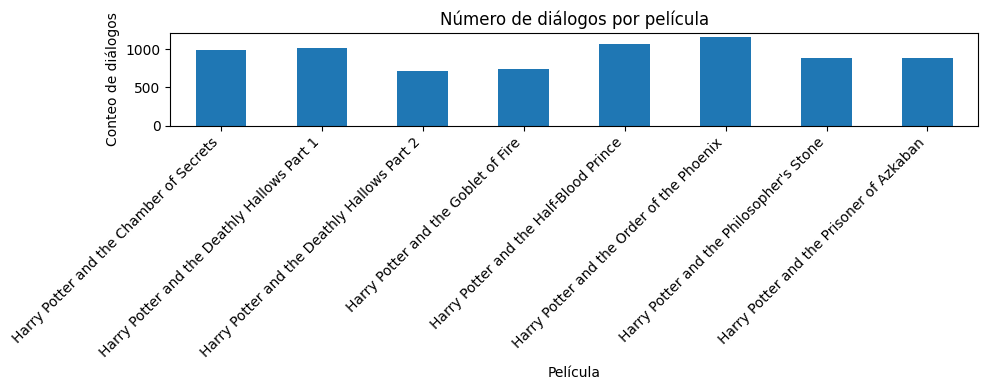

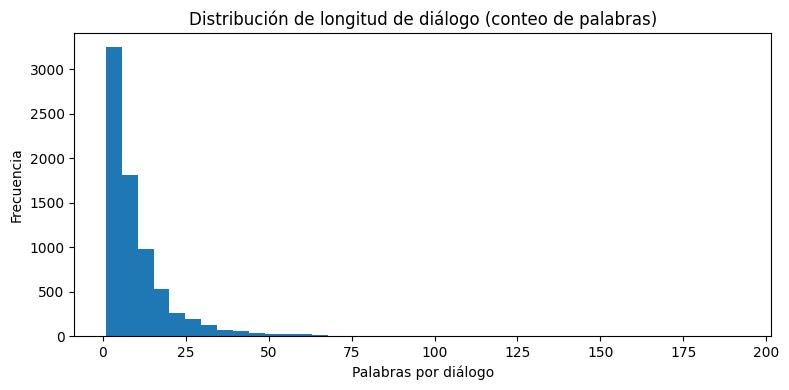

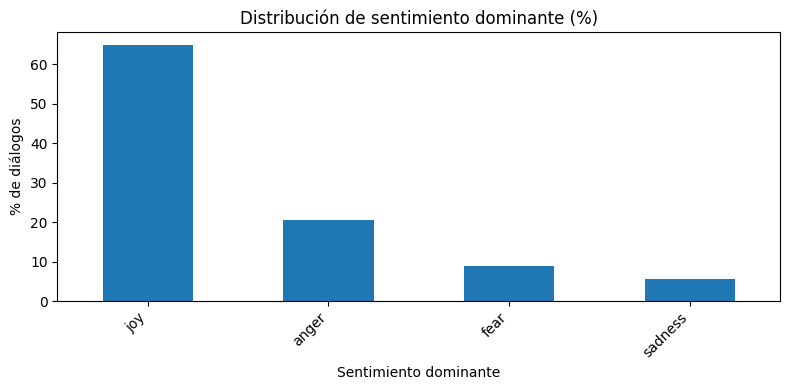

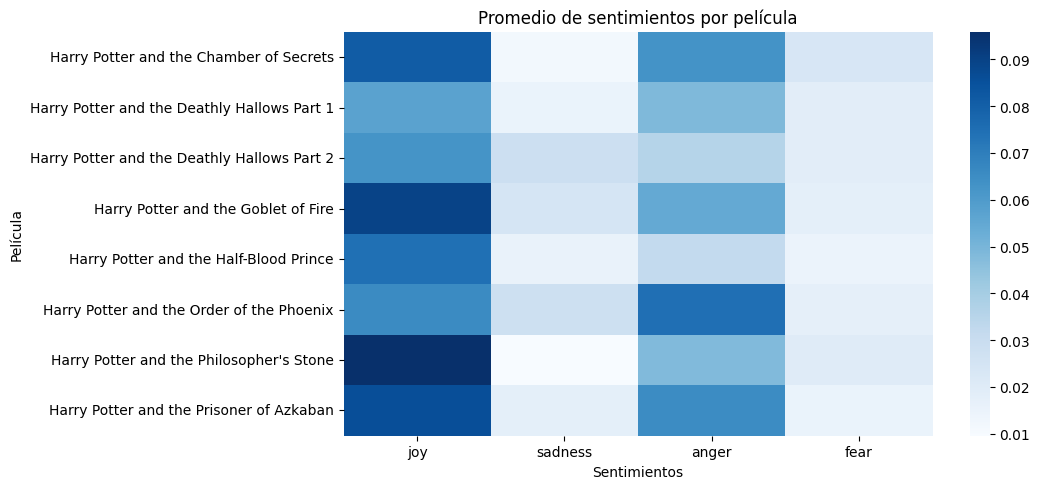

In [7]:
# Diálogos por película
plt.figure(figsize=(10,4))
(df['Movie Title'].value_counts()
 .sort_index()
 .plot(kind='bar'))
plt.title('Número de diálogos por película')
plt.xlabel('Película')
plt.ylabel('Conteo de diálogos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Longitud de diálogo
plt.figure(figsize=(8,4))
plt.hist(df['dialogue_word_count'], bins=40)
plt.title('Distribución de longitud de diálogo (conteo de palabras)')
plt.xlabel('Palabras por diálogo')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Sentimiento dominante
plt.figure(figsize=(8,4))
(df['dominant_sentiment'].value_counts(normalize=True)
 .mul(100)
 .round(1)
 .plot(kind='bar'))
plt.title('Distribución de sentimiento dominante (%)')
plt.xlabel('Sentimiento dominante')
plt.ylabel('% de diálogos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Heatmap: sentimientos promedio por película
sent_by_movie = (
    df.groupby('Movie Title')[SENTIMENT_COLS]
      .mean()
      .sort_index()
)
plt.figure(figsize=(11,5))
sns.heatmap(sent_by_movie, annot=False, cmap='Blues')
plt.title('Promedio de sentimientos por película')
plt.xlabel('Sentimientos')
plt.ylabel('Película')
plt.tight_layout()
plt.show()


## 3) Preparación para clustering

Para segmentar *tipos de escenas* a partir de los diálogos, construimos un espacio de variables compacto y explicable:
- Probabilidades de emociones
- Longitud del diálogo (en log)

**Nota:** el texto del diálogo se usa para *interpretación* (perfilamiento), pero no se utiliza directamente como *bag-of-words* para mantener el modelo simple y defendible en portafolio.


In [8]:
# Matriz de features para clustering
features = SENTIMENT_COLS + ['dialogue_word_count']
X = df[features].copy()

# Transformación log para longitud (reduce sesgo)
X['dialogue_word_count_log'] = np.log1p(X['dialogue_word_count'])
X = X.drop(columns=['dialogue_word_count'])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('X_scaled:', X_scaled.shape)


X_scaled: (7444, 5)


## 4) K-Means

Evaluamos distintos valores de *k* (2 a 10) con:
- **Inercia** (método del codo)
- **Silhouette score**

En el proyecto se eligió **k = 4**, consistente con la estabilidad del codo y un equilibrio entre separación e interpretabilidad.


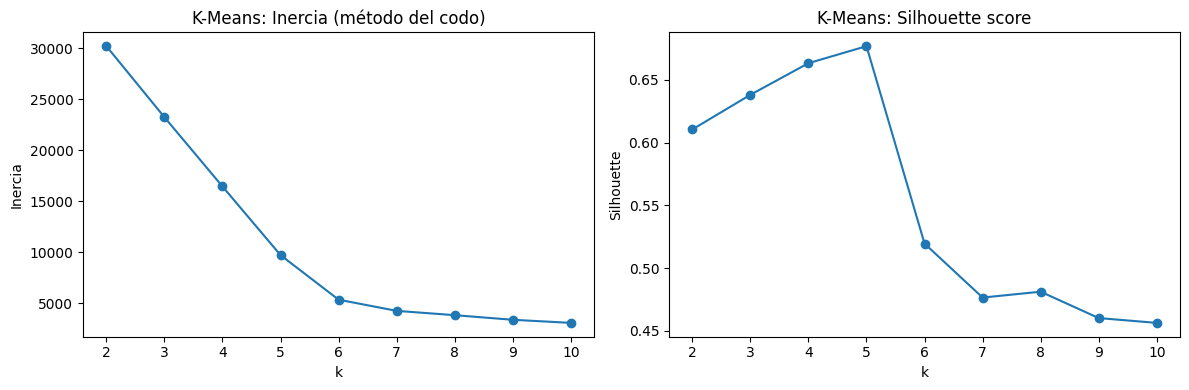

,count
cluster_kmeans,
0,6883
1,361
2,95
3,105


In [9]:
inertias = []
sil_scores = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(ks), inertias, marker='o')
plt.title('K-Means: Inercia (método del codo)')
plt.xlabel('k')
plt.ylabel('Inercia')

plt.subplot(1,2,2)
plt.plot(list(ks), sil_scores, marker='o')
plt.title('K-Means: Silhouette score')
plt.xlabel('k')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()

# Entrenamiento final
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

df['cluster_kmeans'].value_counts().sort_index()


### Métricas complementarias (K-Means)

Además del *silhouette*, calculamos:
- Inercia final
- Distancias entre centroides (mínima y máxima)


In [10]:
inertia_final = kmeans.inertia_
centers = kmeans.cluster_centers_
D = pairwise_distances(centers)
# quitamos diagonal
mask = ~np.eye(D.shape[0], dtype=bool)
min_dist = D[mask].min()
max_dist = D[mask].max()

sil_kmeans = silhouette_score(X_scaled, df['cluster_kmeans'])
print(f'Inercia (k={k_opt}): {inertia_final:.4f}')
print(f'Distancia mínima entre centroides: {min_dist:.4f}')
print(f'Distancia máxima entre centroides: {max_dist:.4f}')
print(f'Silhouette K-Means: {sil_kmeans:.4f}')


Inercia (k=4): 16455.5199
Distancia mínima entre centroides: 4.5115
Distancia máxima entre centroides: 11.6863
Silhouette K-Means: 0.6633


### Perfilamiento de clusters (K-Means)

Se analizan promedios de emociones y longitud de diálogo por cluster, y se listan los personajes más frecuentes por grupo para facilitar interpretación narrativa.


In [11]:
profile_cols = SENTIMENT_COLS + ['dialogue_word_count']
profile_km = df.groupby('cluster_kmeans')[profile_cols].mean().round(4)
profile_km


,joy,sadness,anger,fear,dialogue_word_count
cluster_kmeans,,,,,
0,0.0817,0.0062,0.0121,0.0075,10.1032
1,0.0054,0.0020,0.8704,0.0032,9.5845
2,0.0059,0.0139,0.0038,0.8614,14.7789
3,0.0062,0.8946,0.0025,0.0152,16.2286


In [12]:
# Top personajes por cluster
TOP_N = 8
chars_by_cluster = (
    df.groupby(['cluster_kmeans', 'Character Name'])
      .size()
      .reset_index(name='n')
      .sort_values(['cluster_kmeans', 'n'], ascending=[True, False])
)

for c in sorted(df['cluster_kmeans'].unique()):
    print(f"\nCluster {c} - Top {TOP_N} personajes:")
    display(chars_by_cluster[chars_by_cluster['cluster_kmeans'] == c].head(TOP_N))


Cluster 0 - Top 8 personajes:


,cluster_kmeans,Character Name,n
65,0,Harry Potter,1796
127,0,Ron Weasley,789
67,0,Hermione Granger,785
2,0,Albus Dumbledore,438
129,0,Rubeus Hagrid,203
134,0,Severus Snape,165
68,0,Horace Slughorn,121
92,0,Minerva McGonagall,120



Cluster 1 - Top 8 personajes:


,cluster_kmeans,Character Name,n
181,1,Harry Potter,88
204,1,Ron Weasley,49
182,1,Hermione Granger,41
205,1,Rubeus Hagrid,20
209,1,Sirius Black,11
163,1,Alastor Moody,10
214,1,Vernon Dursley,10
215,1,Voldemort,10



Cluster 2 - Top 8 personajes:


,cluster_kmeans,Character Name,n
234,2,Harry Potter,16
243,2,Ron Weasley,16
221,2,Albus Dumbledore,14
235,2,Hermione Granger,13
238,2,Minerva McGonagall,5
236,2,Horace Slughorn,3
227,2,Cornelius Fudge,2
228,2,Draco Malfoy,2



Cluster 3 - Top 8 personajes:


,cluster_kmeans,Character Name,n
263,3,Harry Potter,22
250,3,Albus Dumbledore,13
274,3,Ron Weasley,11
264,3,Hermione Granger,9
278,3,Sirius Black,5
267,3,Luna Lovegood,4
275,3,Rubeus Hagrid,4
280,3,Voldemort,4


### Visualización (PCA 2D)

Usamos PCA solo para visualizar (no para entrenar).


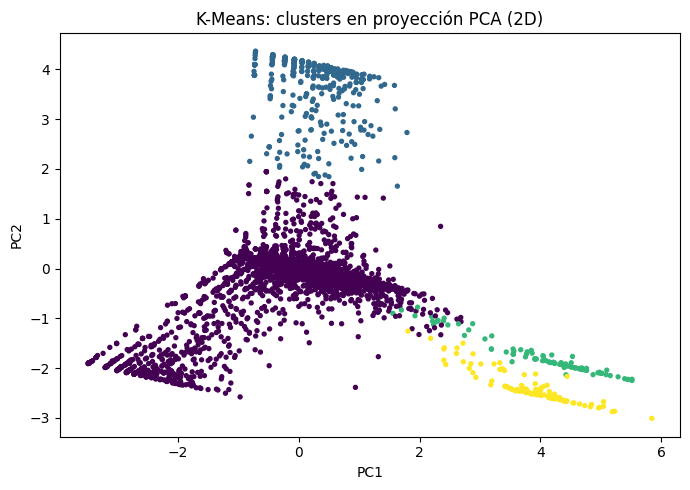

Varianza explicada (2 PCs): [0.23  0.216] Total: 0.446


In [13]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=df['cluster_kmeans'], s=8)
plt.title('K-Means: clusters en proyección PCA (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

print('Varianza explicada (2 PCs):', pca.explained_variance_ratio_.round(3), 'Total:', pca.explained_variance_ratio_.sum().round(3))


## 5) Gaussian Mixture Models (GMM)

Seleccionamos el número de componentes evaluando **AIC** y **BIC**. En la presentación del proyecto, ambos criterios sugieren un mínimo alrededor de **4 clusters**.


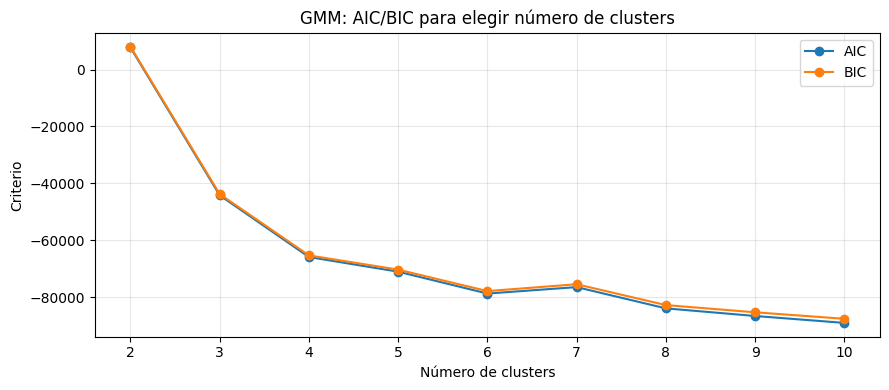

,count
cluster_gmm,
0,4032
1,680
2,1335
3,1397


In [14]:
aic = []
bic = []
components = range(2, 11)

for n in components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    aic.append(gmm.aic(X_scaled))
    bic.append(gmm.bic(X_scaled))

plt.figure(figsize=(9,4))
plt.plot(list(components), aic, marker='o', label='AIC')
plt.plot(list(components), bic, marker='o', label='BIC')
plt.title('GMM: AIC/BIC para elegir número de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Criterio')
plt.xticks(list(components))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Entrenamiento final
n_opt = 4
gmm = GaussianMixture(n_components=n_opt, covariance_type='full', random_state=42)
df['cluster_gmm'] = gmm.fit_predict(X_scaled)

df['cluster_gmm'].value_counts().sort_index()


### Métricas complementarias (GMM)

Calculamos:
- Log-likelihood promedio por muestra (`score`)
- Silhouette score
- Un resumen simple de dispersión por cluster (traza de la covarianza)


In [15]:
loglik_per_sample = gmm.score(X_scaled)
sil_gmm = silhouette_score(X_scaled, df['cluster_gmm'])

# Resumen de covarianzas: traza (suma de varianzas) por cluster
cov_traces = [np.trace(cov) for cov in gmm.covariances_]

print(f'Log-likelihood promedio por muestra: {loglik_per_sample:.4f}')
print(f'Silhouette GMM: {sil_gmm:.4f}')
print('Traza de covarianza por cluster:', np.round(cov_traces, 4))


Log-likelihood promedio por muestra: 4.4393
Silhouette GMM: 0.1630
Traza de covarianza por cluster: [ 0.9617 18.5763  4.8905  4.1508]


### Perfilamiento de clusters (GMM)


In [16]:
profile_gmm = df.groupby('cluster_gmm')[profile_cols].mean().round(4)
profile_gmm


,joy,sadness,anger,fear,dialogue_word_count
cluster_gmm,,,,,
0,0.0109,0.0025,0.0039,0.0038,10.6461
1,0.0309,0.1755,0.0088,0.1569,12.0779
2,0.0092,0.0036,0.2777,0.0083,9.4127
3,0.3495,0.0033,0.0041,0.0024,8.8790


## 6) Comparativa K-Means vs GMM

- **K-Means** tiende a formar clusters compactos (esféricos) y suele separar bien cuando la estructura es simple.
- **GMM** permite clusters elípticos y una segmentación más flexible, pero puede presentar más solapamiento (silhouette menor).

En la presentación original del proyecto se reporta un silhouette alrededor de **0.40** para K-Means y un valor cercano a **0** (incluso negativo) para GMM. Este notebook recalcula ambas métricas con la preparación actual de datos.


In [17]:
summary = pd.DataFrame({
    'modelo': ['K-Means', 'GMM'],
    'n_clusters': [k_opt, n_opt],
    'silhouette': [sil_kmeans, sil_gmm],
    'kmeans_inercia': [inertia_final, np.nan],
    'gmm_loglik': [np.nan, loglik_per_sample],
})
summary


,modelo,n_clusters,silhouette,kmeans_inercia,gmm_loglik
0,K-Means,4,0.663299,16455.519867,NaN
1,GMM,4,0.162998,NaN,4.439339


## 7) Conclusiones

A partir de los clusters y su perfil emocional, es posible interpretar **cuatro tipos de escenas** (visión alineada con la presentación del proyecto):

1. **Interacciones cotidianas**: vida en Hogwarts, conversaciones informativas y diálogos neutros.
2. **Tensión y miedo**: enfrentamientos y descubrimientos peligrosos (fear/anger más altos).
3. **Tragedia y conflicto**: sacrificios, pérdidas o confrontaciones emocionales (sadness/anger).
4. **Momentos épicos**: victorias, esperanza y emoción positiva (joy/surprise).

**Recomendación práctica:** si el objetivo es *segmentar escenas con reglas simples y buena separación*, K-Means suele ser suficiente. Si el objetivo es *capturar diversidad con fronteras más flexibles*, GMM puede aportar, aunque con mayor solapamiento.


---
## Reproducibilidad
1. Coloca `harry_potter_data.csv` en `data/`.
2. Ejecuta el notebook de arriba hacia abajo.

Si trabajas en Google Colab, puedes montar Drive y usar `LOCAL_FALLBACK`.
